In [17]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple
import tools

from tools.FV3_tools import read_solo_fields
from tools.WRF_tools import read_wrf_fields
from tools.CM1_tools import read_cm1_fields

import pickle
from tools.cbook import pickle2Obj

_nthreads = 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def plot_accum_prec(cm1, wrf, solo, allcape, allshear):
    time = 15+15*np.arange(24)
    x = np.arange(5)

    plim = [[1.5e5, 3.0e5, 3.0e5, 3.5e5, 3.5e5],[1.5e5, 3.0e5, 3.0e5, 3.0e5, 3.25e5], [2.0e5, 3.5e5, 3.0e5, 3.5e5, 3.5e5]]

    labels = []
    for cape in allcape:
        labels.append("%s" % (cape[1:]))

    for m, shear in enumerate(allshear):
        for n, cape in enumerate(allcape):
            label = "%s_%s" % (cape, shear)

            fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,3))

            ax.plot(time, cm1[label]['accum_prec'][1:].sum(axis=(1,2)), color='b', linestyle='-', label='CM1')
            ax.plot(time, wrf[label]['accum_prec'][1:].sum(axis=(1,2)), color='k', linestyle='-', label='WRF')
            ax.plot(time, solo[label]['accum_prec'].sum(axis=(1,2)), color='r', linestyle='-', label='FV3-SOLO')

            ax.set_ylabel('Accumulated Precip (mm)', fontsize=16)
            ax.set_xlabel('Time (min)', fontsize=16)
            ax.set_ylim(0, plim[m][n])
            ax.set_title('Total Accumulated Precip for CAPE=%d and SHEAR=%d m/s' % (int(cape[1:]), int(shear)), fontsize=18)
            legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
            plt.show()

In [21]:
# Read in precip and w data

dirs    = {
           "solo": "/work/wicker/Odin_scr/solo",
           "wrf": "/work/wicker/WRF/WRF/test/em_quarter_ss",
           "cm1": "/work/wicker/Odin_scr/cm1r20.3/run",
          }

run      = {"solo": "squall_3km", "wrf": "squall_3km", "cm1": "squall_3km"}
run      = {"solo": "squall_3km"}

allcape = ("C2000", "C3500")
allshear = ("06", "18")

solo = {}
cm1  = {}
wrf  = {}

for n, key in enumerate(run):
    
    field = {}
    
    for shear in allshear:
        for cape in allcape:

            label = "%s_%s" % (cape, shear)

            path = str(os.path.join(dirs[key], "%s_%s" % (run[key], label)))
            
            if n == 0:
                solo[label] = read_solo_fields(path, file_pattern=None, vars=['accum_prec'])
                
            if n == 1:

                wrf[label] = read_wrf_fields(path, file_pattern=None, vars=['accum_prec'])

            if n == 2:
                cm1[label] = read_cm1_fields(path, file_pattern=None, vars=['accum_prec'])
                
for n, key in enumerate(run):
    
     if n == 0:
            with open('solo_%s_accum_prec.pkl' % run['solo'], 'wb') as handle:
                pickle.dump(solo, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('wrf_%s_accum_prec.pkl' % run['wrf'], 'wb') as handle:
#     pickle.dump(wrf, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('cm1_%s_accum_prec.pkl' % run['cm1'], 'wb') as handle:
#     pickle.dump(cm1, handle, protocol=pickle.HIGHEST_PROTOCOL)

                

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/squall_3km_C2000_06/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/solo/squall_3km_C2000_06/atmos_hifreq.nc 

 Completed reading in:  /work/wicker/Odin_scr/solo/squall_3km_C2000_06/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/squall_3km_C3500_06/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work

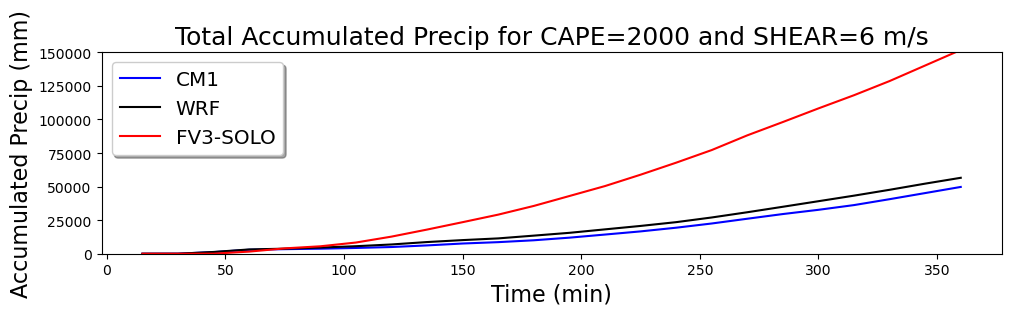

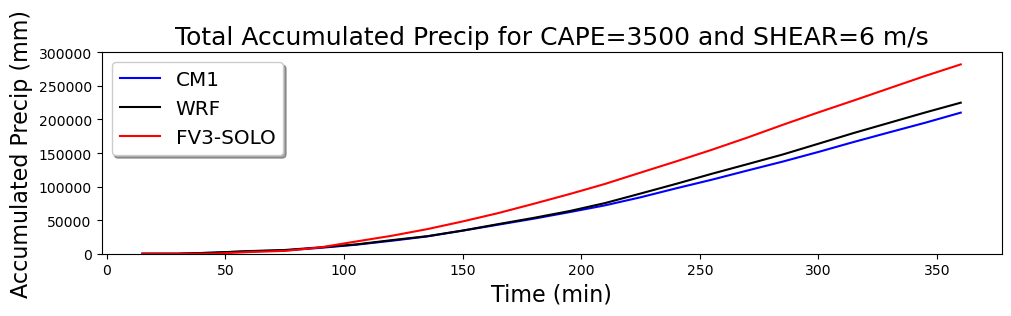

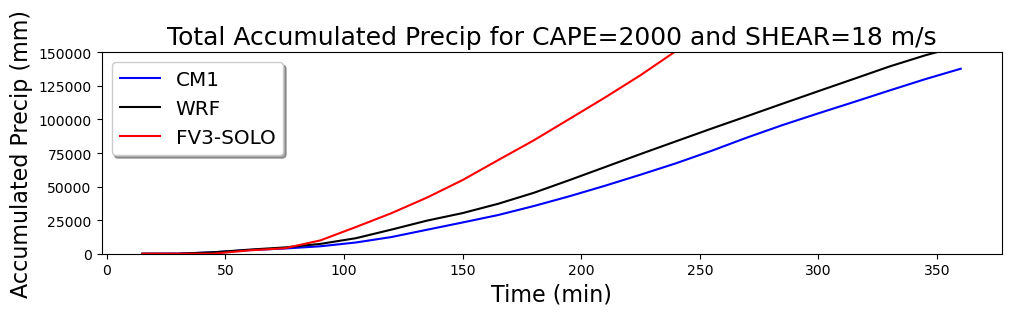

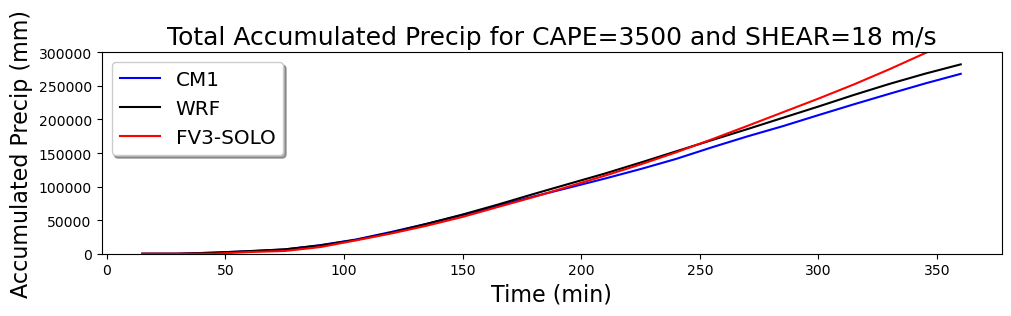

In [24]:
cm1 = pickle2Obj('cm1_squall_3km_accum_prec.pkl',retObj=False) 
wrf = pickle2Obj('wrf_squall_3km_accum_prec.pkl', retObj=False)
solo = pickle2Obj('solo_squall_nw0_accum_prec.pkl',retObj=False)

plot_accum_prec(cm1, wrf, solo, allcape, allshear)


In [21]:
wrf['C3500_06']['accum_prec']

KeyError: 'accum_prec'

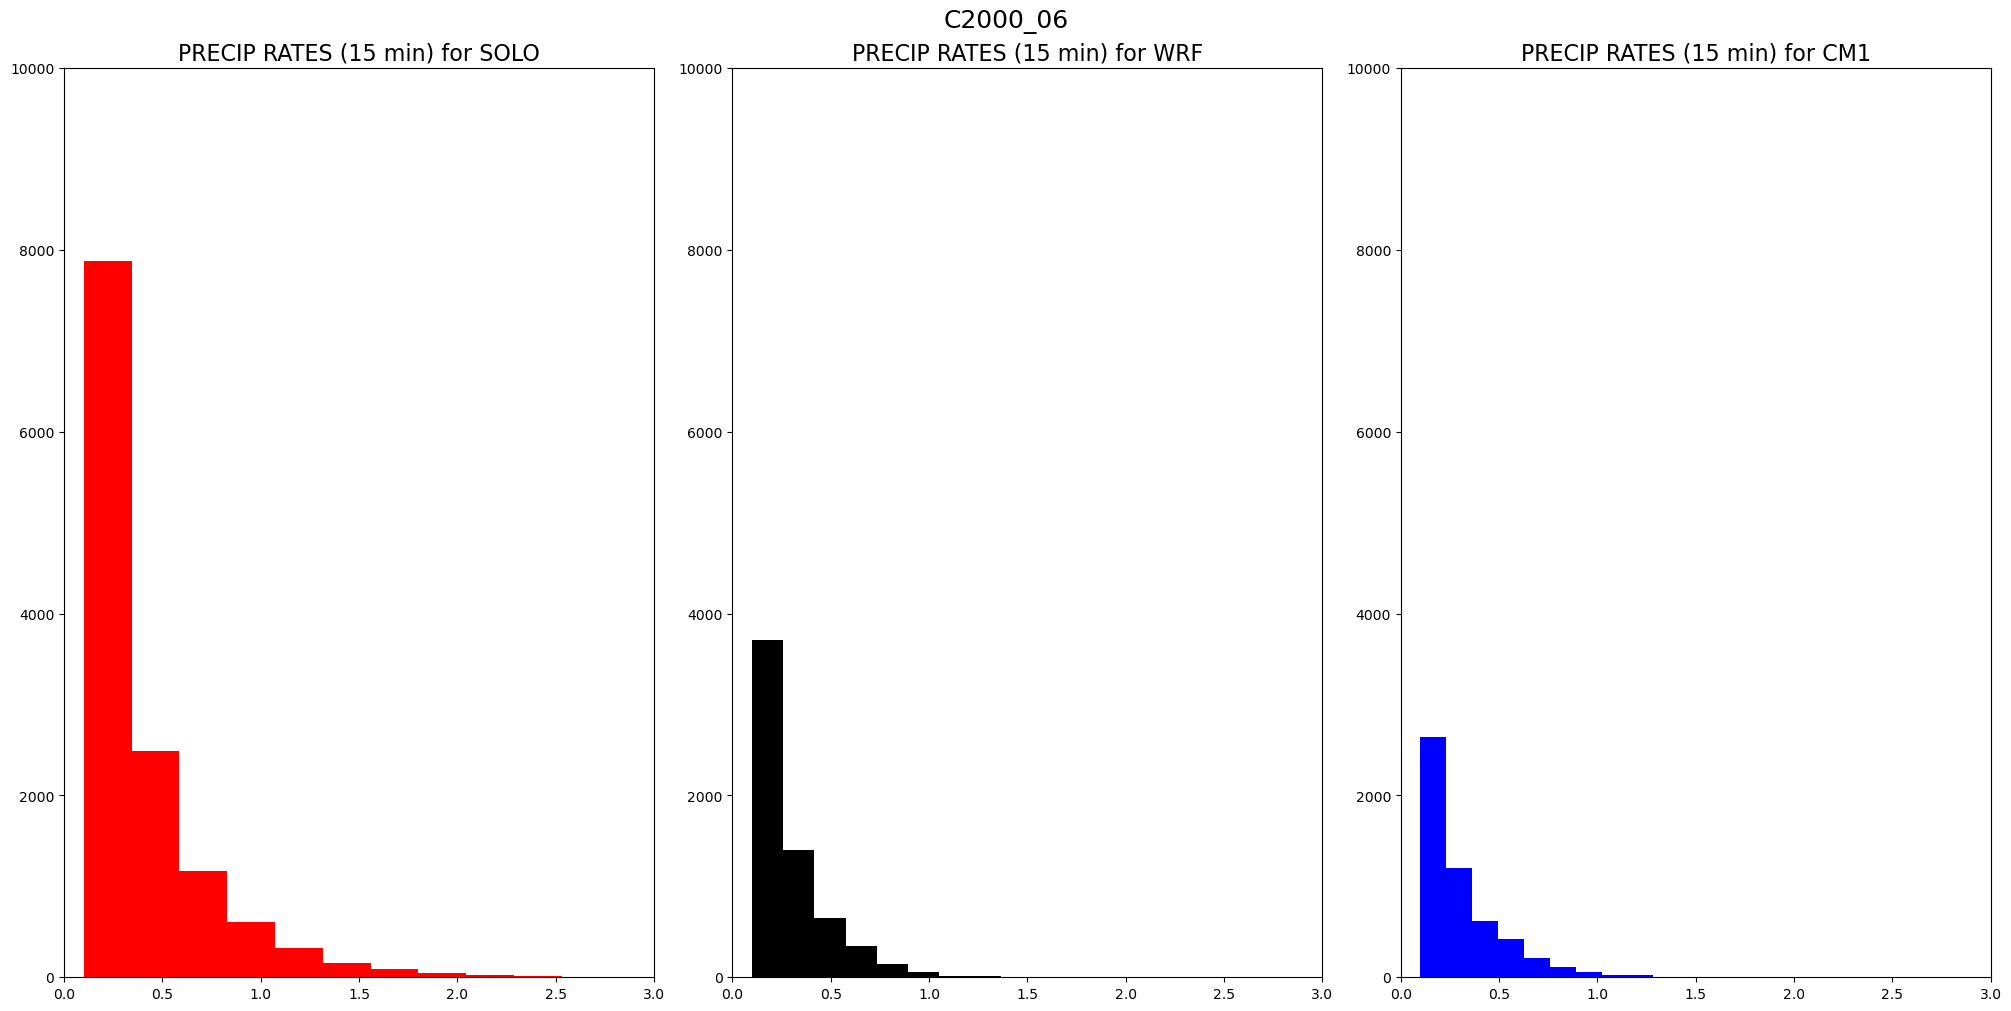

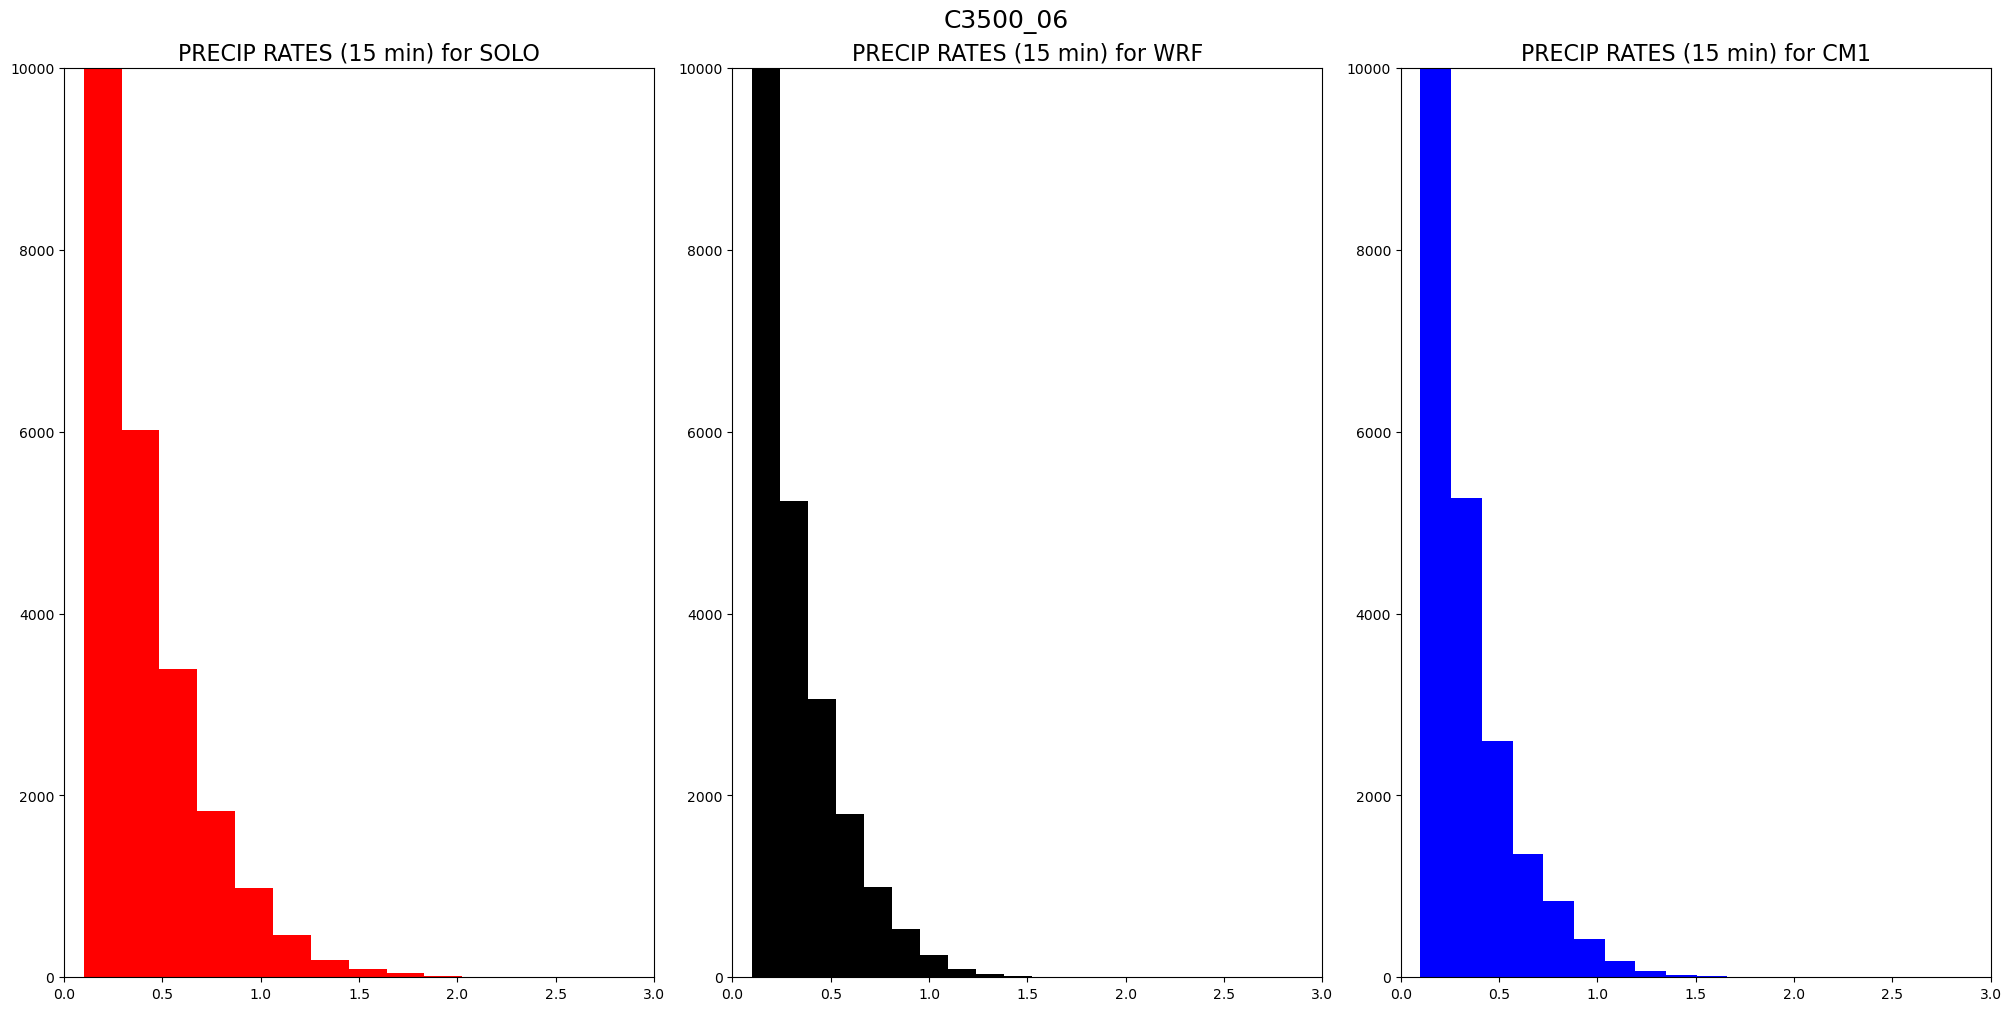

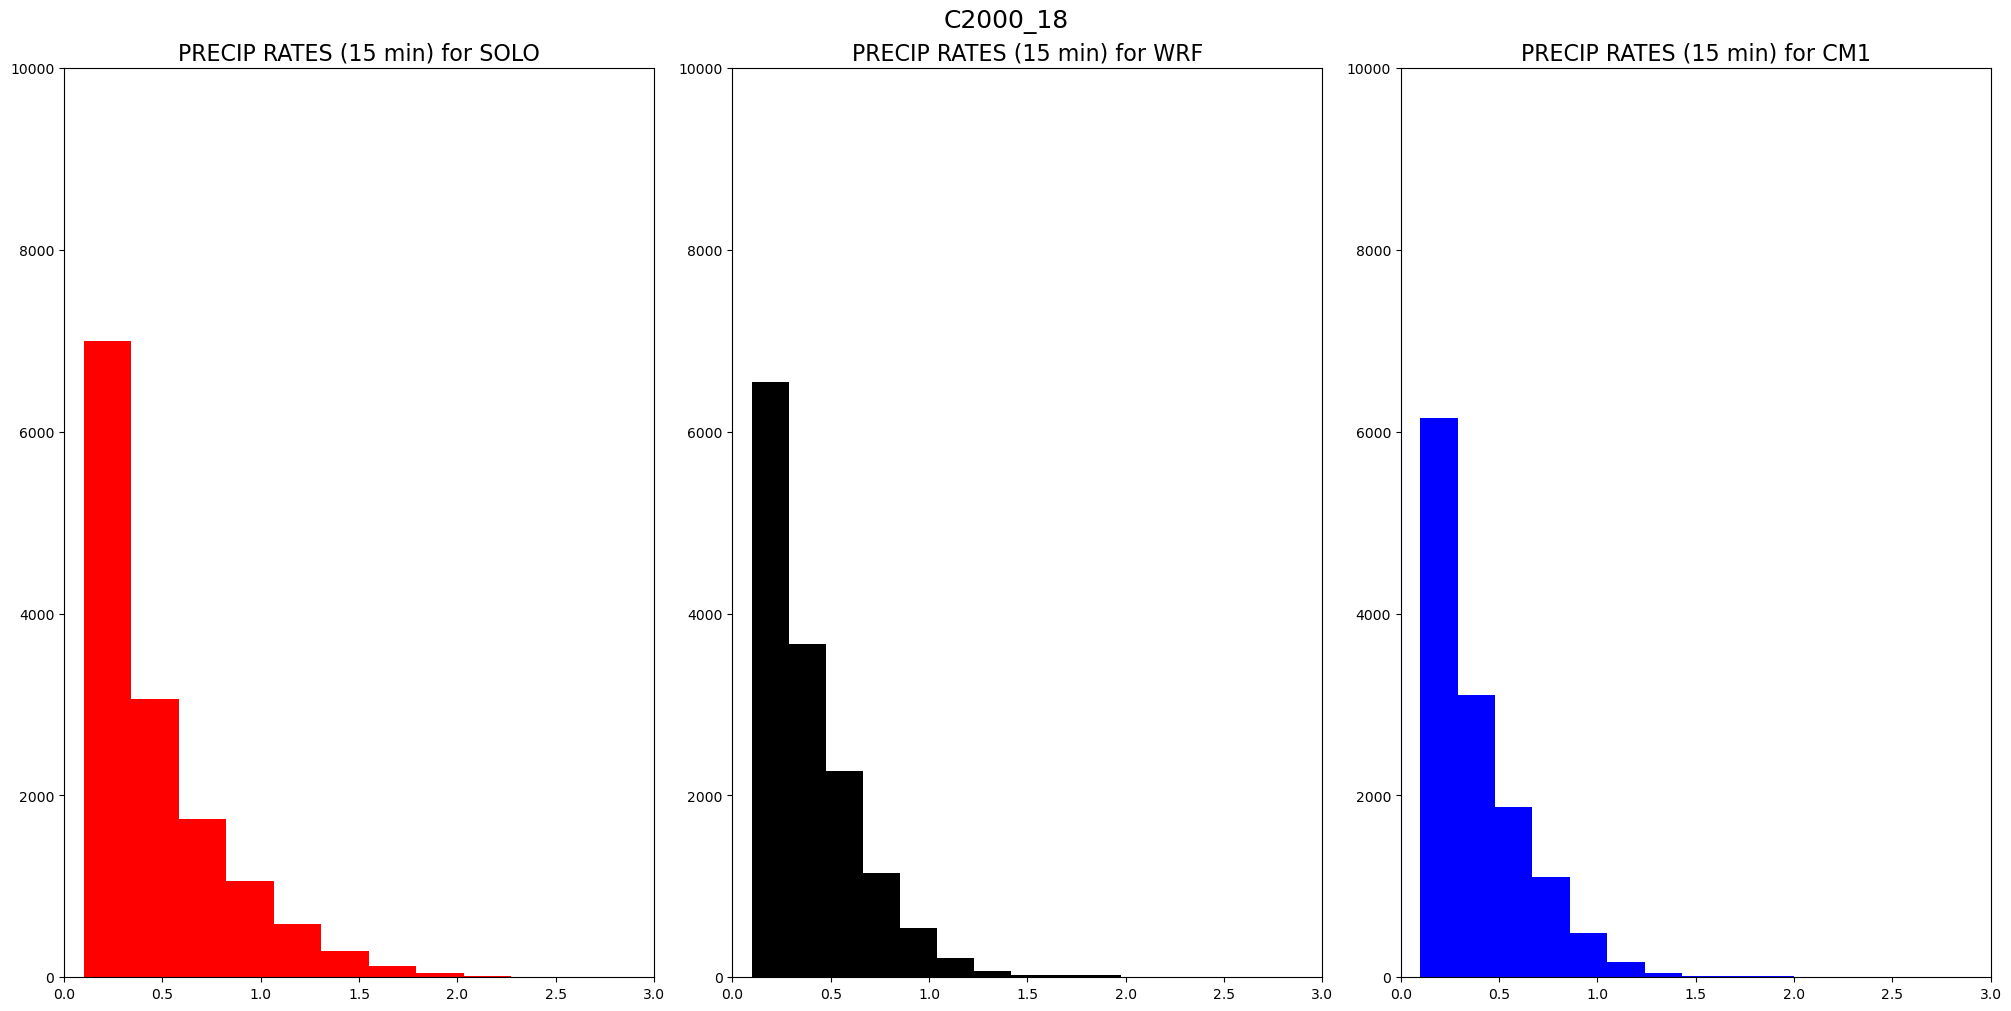

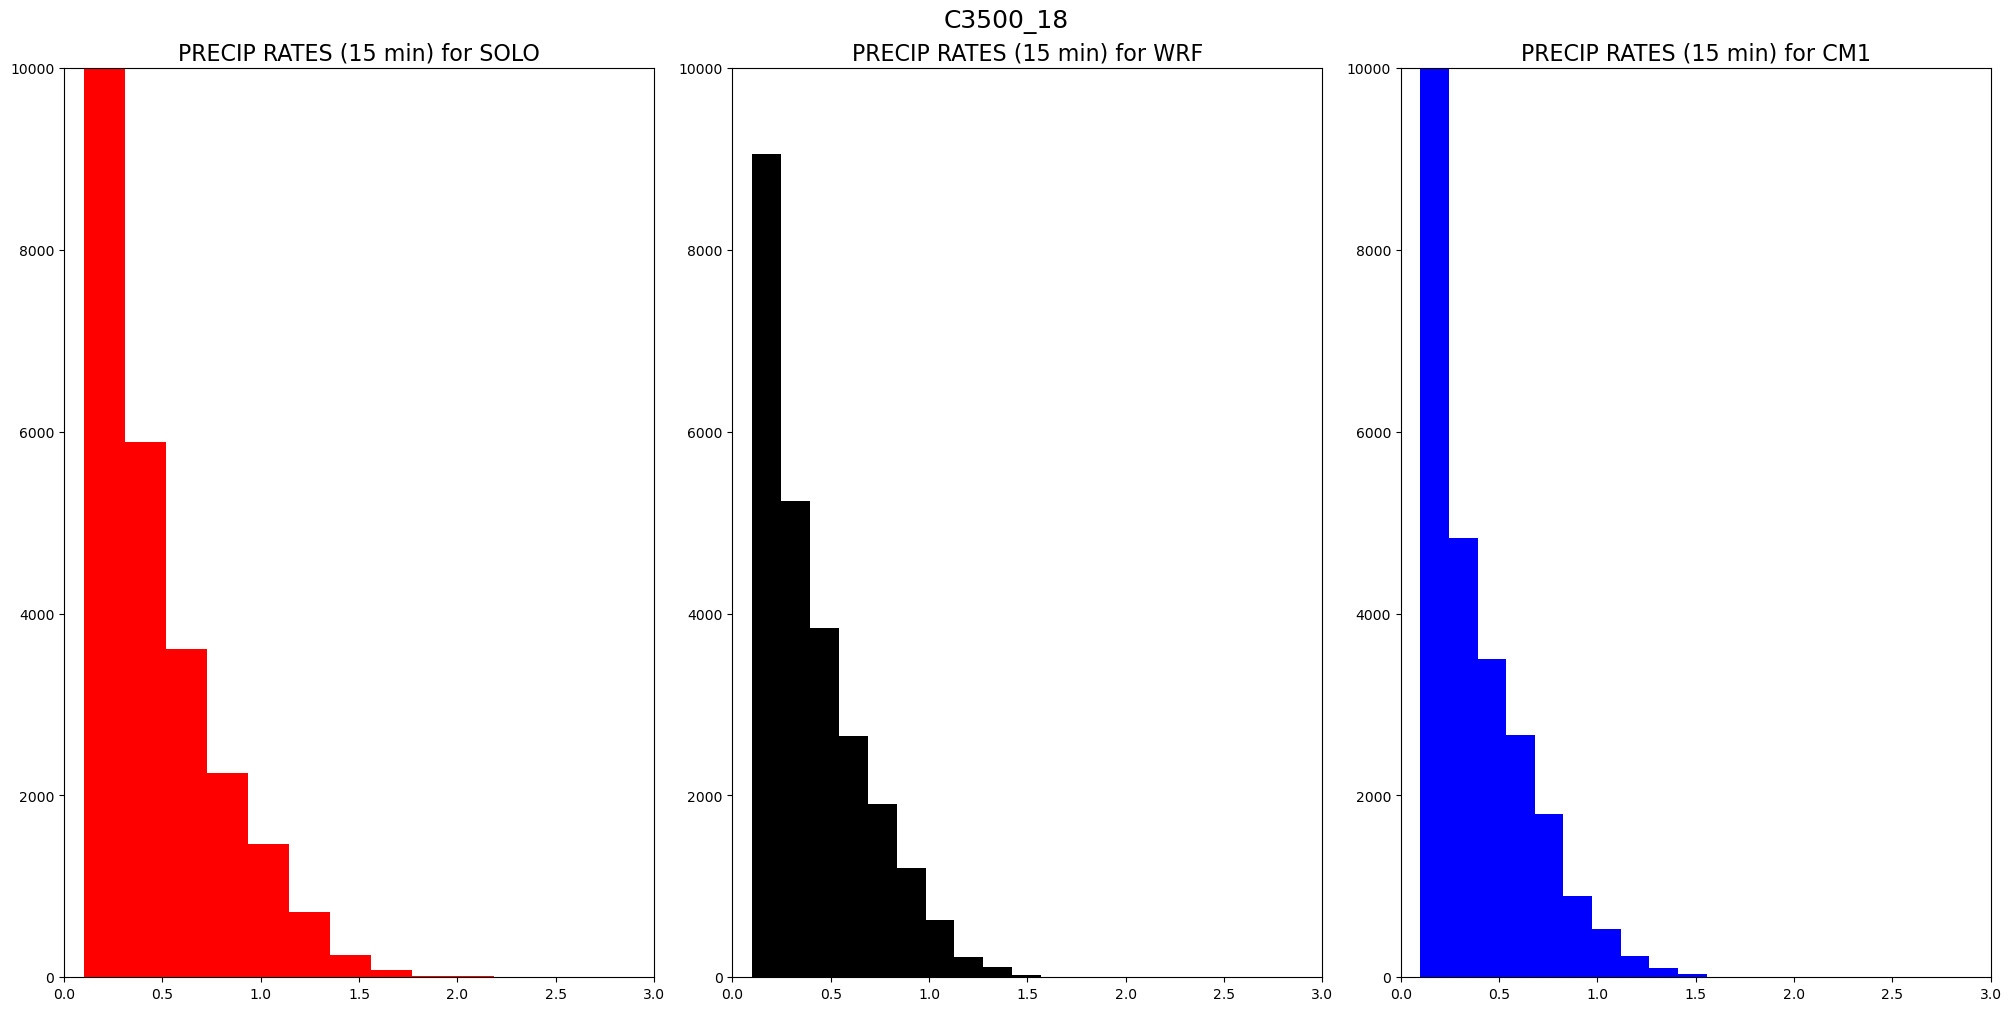

In [23]:
thres = 25.5 # mm -> inches 1"

def compute_precip(acc_precip):
    
    nt = acc_precip.shape[0]
    
    precip = np.zeros_like(acc_precip)
    
    for m in np.arange(1,nt):
        n = nt - m - 1 
        precip[n] = acc_precip[n+1] - acc_precip[n]
        
    # print("Checking:  ",(precip.sum(axis=0) - acc_precip[-1]).max())
        
    return precip/thres
    

for m, shear in enumerate(allshear):
    for n, cape in enumerate(allcape):
        label = "%s_%s" % (cape, shear)
        
        p_solo = compute_precip(solo[label]['accum_prec'])
        p_cm1  = compute_precip(cm1[label]['accum_prec'])
        p_wrf  = compute_precip(wrf[label]['accum_prec'])
    
        fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

        ax[0].hist(p_solo[p_solo > 0.1], bins=10, color='red')
        ax[0].set_ylim(0.0,10000.)
        ax[0].set_xlim(0,3)
        ax[0].set_title("PRECIP RATES (15 min) for SOLO", fontsize=16)

        ax[1].hist(p_wrf[p_wrf > 0.1], bins=10, color='black')
        ax[1].set_ylim(0.0,10000.)
        ax[1].set_xlim(0,3)
        ax[1].set_title("PRECIP RATES (15 min) for WRF", fontsize=16)

        ax[2].hist(p_cm1[p_cm1 > 0.1], bins=10, color='blue')
        ax[2].set_ylim(0.0,10000.)
        ax[2].set_xlim(0,3)
        ax[2].set_title("PRECIP RATES (15 min) for CM1", fontsize=16)
        
        plt.suptitle("%s" % (label), fontsize=18)

plt.show()

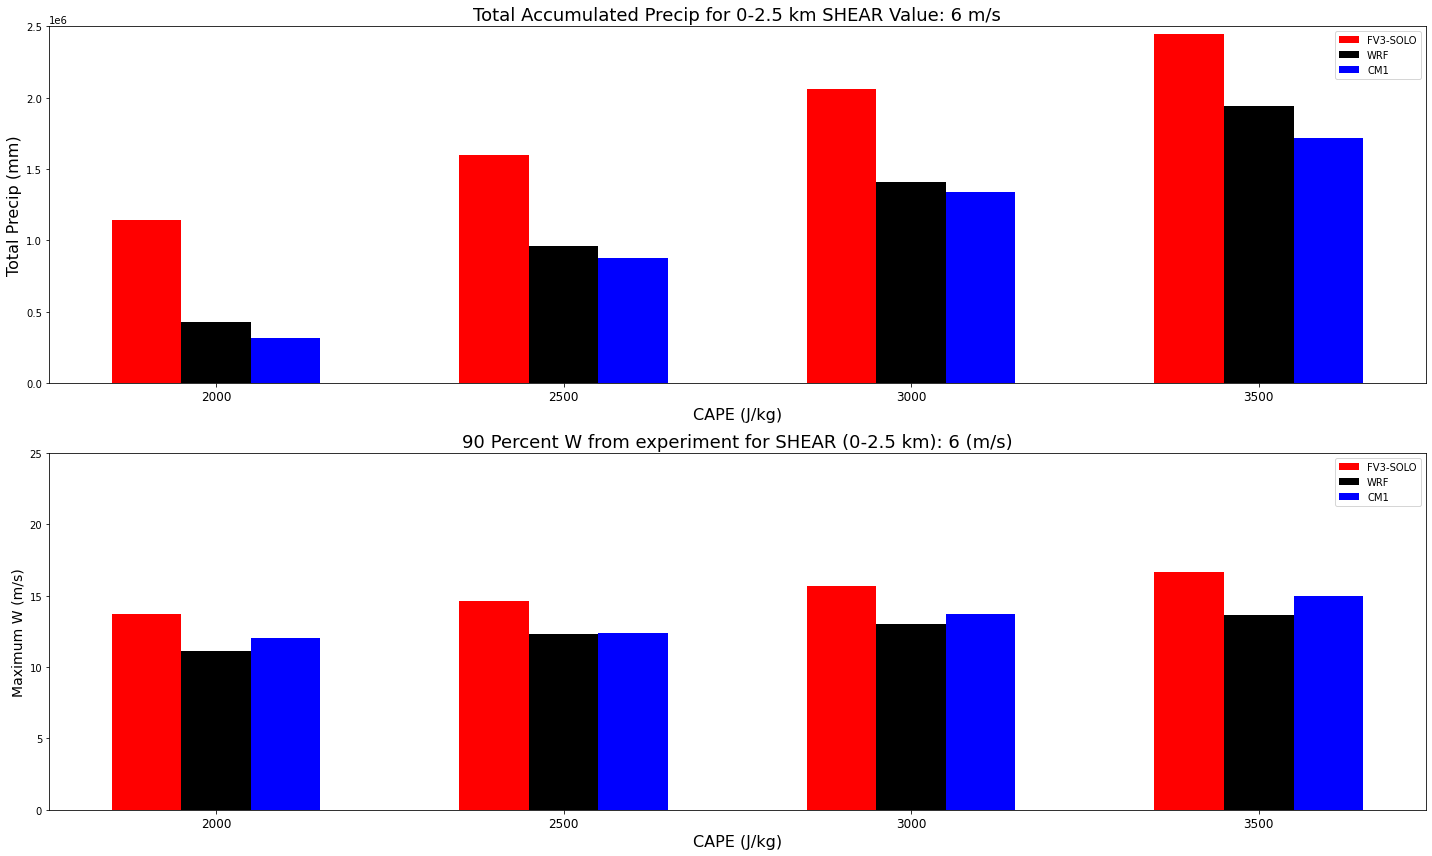

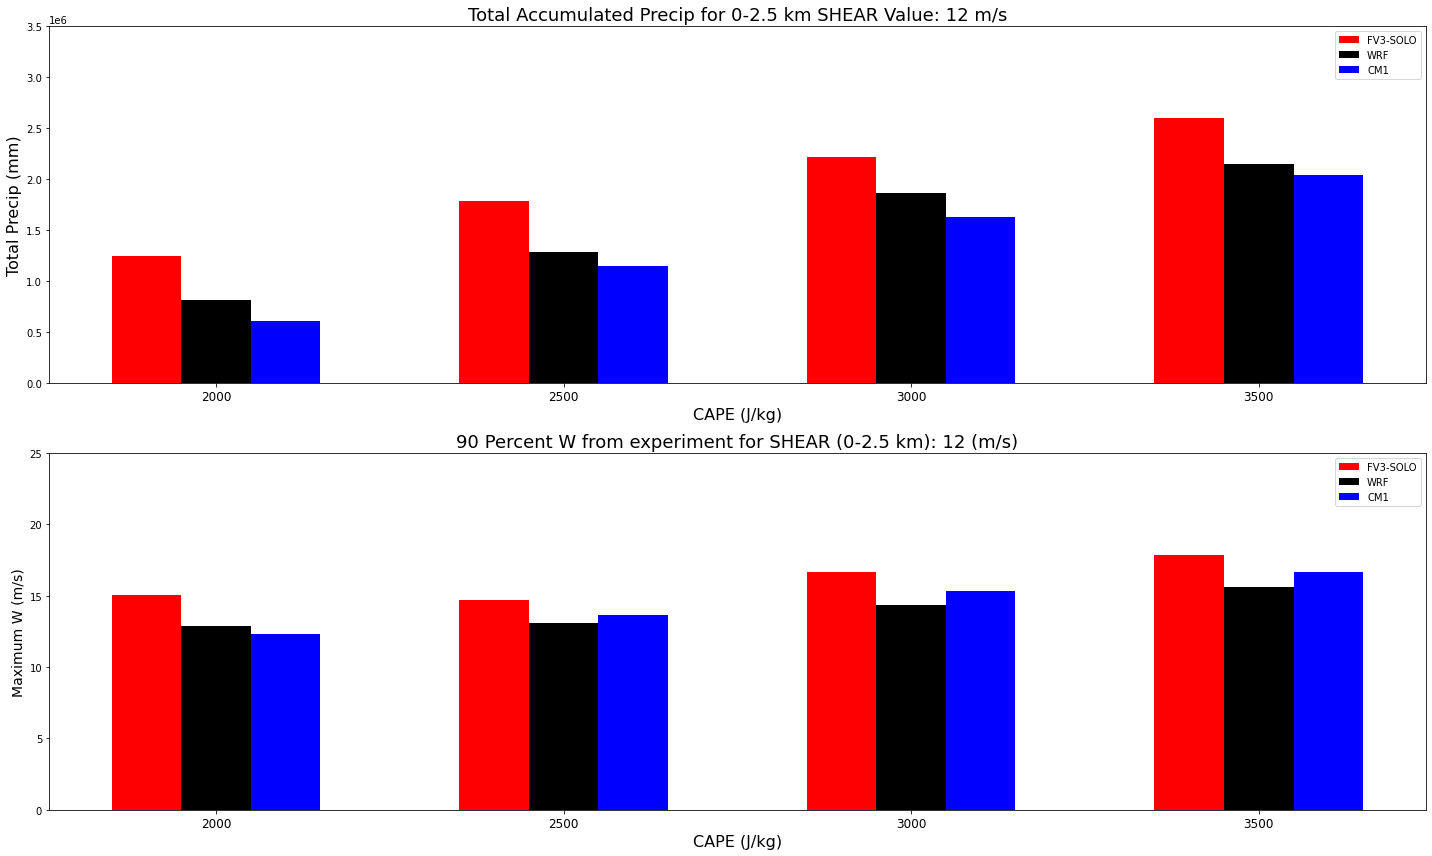

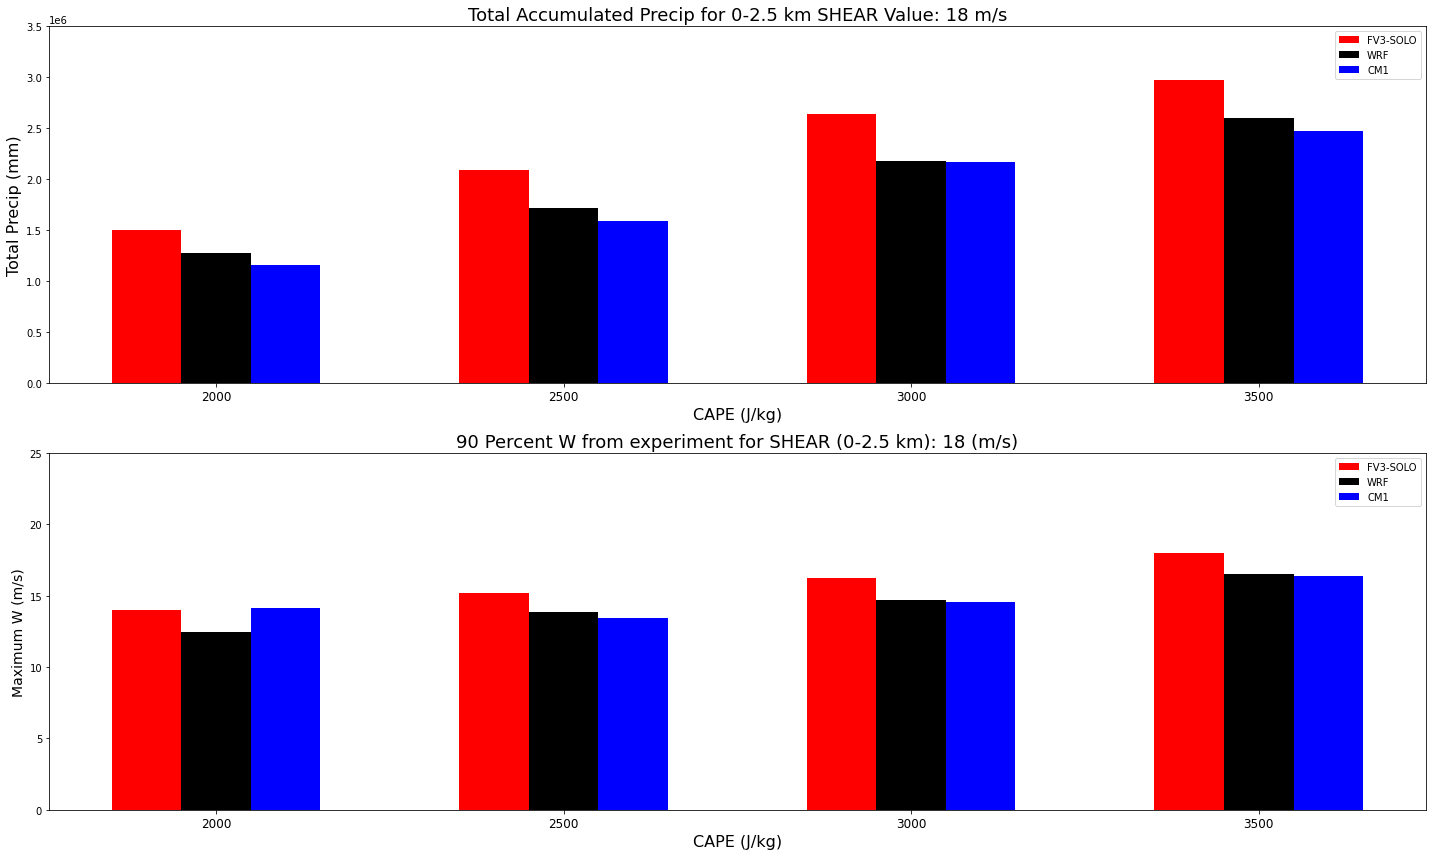

In [38]:
def wpercent(w3d, percent):
    
    w = np.sort(w3d.flatten(), kind='quicksort')
    
    n = int(len(w)*percent/100.)

    return w[n]

########################
x = np.arange(4)

wlim = [25., 25., 25.]
plim = [2.5e6, 3.5e6, 3.5e6]

allcape = ("C2000", "C2500", "C3000", "C3500")
allshear = ("06","12", "18")


labels = []
for cape in allcape:
    labels.append("%s" % (cape[1:]))
    
for n, shear in enumerate(allshear):
    
    fig, axes = plt.subplots(2,1, constrained_layout=True,figsize=(20,12))    
    slist = []
    wlist = []
    clist = []

    for cape in allcape:
        label = "%s_%s" % (cape, shear)
        
        slist.append(solo[label]['acc_precip'].sum())
        wlist.append(wrf[label]['acc_precip'].sum())
        clist.append(cm1[label]['acc_precip'].sum())
        
    ax = axes[0]

    width = 0.2  # the width of the bars
    sbar = ax.bar(x - width, slist, width, color='r', label='FV3-SOLO')
    wbar = ax.bar(x ,        wlist, width, color='k', label='WRF')
    cbar = ax.bar(x + width, clist, width, color='b', label='CM1')

    ax.set_ylabel('Total Precip (mm)', fontsize=16)
    ax.set_xlabel('CAPE (J/kg)', fontsize=16)
    ax.set_ylim(0, plim[n])
    ax.set_title('Total Accumulated Precip for 0-2.5 km SHEAR Value: %d m/s' % int(shear), fontsize=18)
    ax.set_xticks(x, labels, fontsize=12)
    ax.legend()
    
    slist = []
    wlist = []
    clist = []
    smax  = []
    wmax  = []
    cmax  = []

    for cape in allcape:
        label = "%s_%s" % (cape, shear)
                
        slist.append(wpercent(solo[label]['w'][solo[label]['w']> 3.0], 95.))
        wlist.append(wpercent(wrf[label]['w'][wrf[label]['w']> 3.0], 95.))
        clist.append(wpercent(cm1[label]['w'][cm1[label]['w']> 3.0], 95.))
        
    ax = axes[1]

    width = 0.2  # the width of the bars
    sbar = ax.bar(x - width, slist, width, color='r', label='FV3-SOLO')

    wbar = ax.bar(x ,        wlist, width, color='k', label='WRF')

    cbar = ax.bar(x + width, clist, width, color='b', label='CM1')
        
    ax.set_ylabel('Maximum W (m/s)', fontsize=14)
    ax.set_xlabel('CAPE (J/kg)', fontsize=16)
    ax.set_ylim(0, wlim[n])
    ax.set_title('90 Percent W from experiment for SHEAR (0-2.5 km): %d (m/s)' % int(shear), fontsize=18)
    ax.set_xticks(x, labels, fontsize=12)
    ax.legend()

    fig.tight_layout()

    plt.savefig('squall_3km_%s.png' % label, dpi=300)
    plt.show()

    del(sbar)
    del(wbar)
    del(cbar)

